In [ ]:
import numpy
import time
import matplotlib.pyplot as plt
import os
import sys 
import nest
import nest.raster_plot
print(nest.version())

nest.ResetKernel()
startbuild = time.time()

NEST HEAD@63efc4393


#### Definition of normalization functions
These functions compute the post-synaptic potential (PSP) based on the neurons' membrane parameters and synaptic decay

In [ ]:
def LambertWm1(x):
    return nest.ll_api.sli_func('LambertWm1', float(x))

def ComputePSPNorm(tau_mem, C_mem, tau_syn):
    a = (tau_mem / tau_syn)
    b = (1.0 / tau_syn -1.0 / tau_mem)
    t_max = 1.0 / b * (-LambertWm1(-numpy.exp(-1.0/a)/a) - 1.0 / a)
    return (numpy.exp(1.0) / (tau_syn * (C_mem * b) * 
            ((numpy.exp( -t_max / tau_mem) - numpy.exp(-t_max / tau_syn)) / b - 
            t_max * numpy.exp(-t_max / tau_syn))))

#### Assigning the simulation parameters to variables.

In [ ]:
dt = 0.1    # the resolution in ms
simtime = 1000.0  # Simulation time in ms
delay_AMPA = 30.0  # synaptic delay in ms
delay_NMDA = 30.0
delay_GABA = 0.5
delay_noise = 25.
delay_stim = delay_noise

In [ ]:
g = 5.0  # ratio inhibitory weight/excitatory weight
eta_ex = 0.7 # external rate relative to threshold rate
eta_in = 0.701
eta_stim = 0.11 #DA CAMBIARE 

epsilon_ex_AB = 0.075  # connection probability 
epsilon_ex_in = 0.15
epsilon_in_AB = 0.493
epsilon_rec_ex = 0.3
epsilon_rec_in = 0.2

epsilon_ex_tot = epsilon_ex_AB + epsilon_rec_ex + epsilon_ex_in

Network numerosities 

In [ ]:
order = 200
NA = 2 * order  # number of excitatory neurons in pop A
NB = 2 * order  # number of excitatory neurons in pop B
NI = 1 * order  # number of inhibitory neurons
N_neurons = NA + NB + NI   # number of neurons in total
N_rec = order * (2+2+1)  # record from all neurons

#### Definition of connectivity parameters

In [ ]:
CA = int(epsilon_ex_tot * NA)
CE = int(epsilon_ex_tot * (NA + NB))  # number of excitatory synapses per neuron #TODO: synapses per neuron should be NMDA+AMPA
CI = int(epsilon_in * NI)  # number of inhibitory synapses per neuron
C_tot = int(CI + CE)      # total number of synapses per neuron

#### Initialization of the parameters of the integrate and fire neurons and synapses. 


In [ ]:
tauMem = 20.0  # time constant of membrane potential in ms
theta = -55.0  # membrane threshold potential in mV

nr_ports = 4  # number of receptor types (noise-related, AMPA, NMDA, GABA)
tau_syn = [14.1, 2., 100., 5.0]  # [ms] DECAY

V_membrane = -70.0  # mV 
V_threshold = -50.0  # mV
V_reset = -55.0  # mV 

Storing the excitatory and inhibitory neurons' parameters in corresponding dictionaries
#### Excitatory

In [ ]:
exc_neuron_params = {
    "E_L": V_membrane,
    "V_th": V_threshold,
    "V_reset": V_reset,
    "C_m": 500.0,  # pF (0.5nF)
    "tau_m": 20.0,
    "t_ref": 2.0, 
    "tau_syn": tau_syn
}

#### Inhibitory

In [ ]:
inh_neuron_params = {
    "E_L": V_membrane,
    "V_th": V_threshold,
    "V_reset": V_reset,
    "C_m": 200.0,  # pF (0.2nF)  
    "tau_m": 10.0,
    "t_ref": 1.0,
    "tau_syn": tau_syn 
} 

The synaptic currents are normalized such that the amplitude of the PSP is J and each connection weight is calibrated on the specific neurotransmitter time constant (from Brunel 2001)

In [ ]:
J = 0.1 # mV -> this means that it takes 200 simultaneous events to drive the spiking activity 

J_unit_noise = ComputePSPNorm(20.0, 500.0, 14.1)
J_norm_noise = J / J_unit_noise 

J_norm_stim = J_norm_noise

J_unit_AMPA = ComputePSPNorm(20.0, 500.0, 2.0)
J_norm_AMPA = J / J_unit_AMPA 

J_unit_NMDA = ComputePSPNorm(20.0, 500.0, 100.0)
J_norm_NMDA = J / J_unit_NMDA 

J_unit_GABA = ComputePSPNorm(10.0, 200.0, 5.0) 
J_norm_GABA = J / J_unit_GABA

<ipython-input-340-dfe316cc6e7d>:8: RuntimeWarning:divide by zero encountered in double_scalars


Definition of threshold rate, which is the external rate needed to fix the membrane potential around its threshold, the external firing rate and the rate of the poisson generator which is multiplied by the in-degree CE and converted to Hz by multiplication by 1000.

In [ ]:
nu_th_noise = (numpy.abs(V_threshold) * 500.0) / (J_norm_noise * CE * numpy.exp(1) * 20.0 * 10.0)
nu_ex = eta_ex*nu_th_noise
p_rate = 1000.0 * nu_ex * CE

In [ ]:
nu_th_noise_in = (numpy.abs(V_threshold) * 200.0) / (J_norm_noise * CI * numpy.exp(1) * 10.0 * 10.0)
nu_in = eta_in * nu_th_noise_in
p_rate_in = 1000.0 * nu_in * CI

print(p_rate_in)
print(p_rate)

3389.6845139365055
4231.061269178947


In [ ]:
nu_th_stim = (numpy.abs(V_threshold) * 500.0) / (J_norm_stim * CA * numpy.exp(1) * 20.0 * 10.0)
nu_stim = eta_stim * nu_th_stim
p_rate_stim = 1000.0 * nu_stim * CA

print(p_rate_stim)

664.8810565852633


Configuration of the simulation kernel by the previously defined time resolution used in the simulation. Setting print_time to True prints the already processed simulation time as well as its percentage of the total simulation time.

In [ ]:
nest.SetKernelStatus({"resolution": dt, "print_time": True,
                      "overwrite_files": True})

### Building the network
Creation of the nodes using Create. We store the returned handles in variables for later reference. Here the excitatory and inhibitory, as well as the poisson generator and three spike recorders. The spike recorders will later be used to record excitatory and inhibitory spikes. Properties of the nodes are specified via SetDefaults, which expects a dictionary.

In [ ]:
nest.SetDefaults("iaf_psc_exp_multisynapse", exc_neuron_params)
pop_A = nest.Create("iaf_psc_exp_multisynapse", NA)
pop_B = nest.Create("iaf_psc_exp_multisynapse", NB)

nest.SetDefaults("iaf_psc_exp_multisynapse", inh_neuron_params)
pop_inh = nest.Create("iaf_psc_exp_multisynapse", NI)

nest.SetDefaults("poisson_generator", {"rate": p_rate})
PG_noise = nest.Create("poisson_generator")

nest.SetDefaults("poisson_generator", {"rate": p_rate_in})
PG_noise_in = nest.Create("poisson_generator")

nest.SetDefaults("poisson_generator", {"rate": p_rate_stim, "origin": 0., "start": 200.,"stop": 600.})
PG_stim = nest.Create("poisson_generator")
#TODO check stimolo più lungo(saturazione?) e stimolo più corto(still ramping?)

spikes_a = nest.Create("spike_detector")
spikes_b = nest.Create("spike_detector")
spikes_i = nest.Create("spike_detector")

#### Assign NEST-related details to populations

In [ ]:
nest.SetStatus(spikes_a, [{"label": "Exc. pop. A",
                          "withtime": True,
                          "withgid": True,
                          "to_file": True}])

nest.SetStatus(spikes_b, [{"label": "Exc. pop. B",
                          "withtime": True,
                          "withgid": True,
                          "to_file": True}])

nest.SetStatus(spikes_i, [{"label": "Inh. pop.",
                          "withtime": True,
                          "withgid": True,
                          "to_file": True}])

### Synapse model definition
Definition of a synapse using CopyModel, which expects the model name of a pre-defined synapse, the name of the customary synapse and an optional parameter dictionary. The parameters defined in the dictionary will be the default parameter for the customary synapse. Here we define one synapse for the excitatory and one for the inhibitory connections giving the previously defined weights and equal delays.

In [ ]:
nest.CopyModel("static_synapse", "excitatory_AMPA",
               {"weight": J_norm_AMPA, "delay": delay_AMPA})
nest.CopyModel("static_synapse", "excitatory_NMDA",
               {"weight": J_norm_NMDA, "delay": delay_NMDA})
nest.CopyModel("static_synapse", "noise_syn",
               {"weight": J_norm_noise, "delay": delay_noise})
nest.CopyModel("static_synapse", "excitatory_stim",
               {"weight": J_norm_stim, "delay": delay_stim})
nest.CopyModel("static_synapse", "inhibitory",
               {"weight": -J_norm_GABA, "delay": delay_GABA})

Assign the corresponding receptor type to each of the synapses models defined above 

In [ ]:
noise_syn = {"model": "noise_syn",
                 "receptor_type": 1}
stim_syn = {"model": "excitatory_stim",
                 "receptor_type": 1}
AMPA_syn = {"model": "excitatory_AMPA",
                 "receptor_type": 2}
NMDA_syn = {"model": "excitatory_NMDA",
                 "receptor_type": 3}
GABA_syn = {"model": "inhibitory",
                 "receptor_type": 4}

### Connecting Devices
Connecting the previously defined poisson generator to the excitatory and inhibitory neurons using the excitatory synapse. Since the poisson generator is connected to all neurons in the population the default rule (all_to_all) of Connect is used. The synaptic properties are inserted via syn_spec which expects a dictionary when defining multiple variables or a string when simply using a pre-defined synapse.

In [ ]:
#noise rate dep to number of syns
#External noise to populations
nest.Connect(PG_noise, pop_A, syn_spec=noise_syn)
nest.Connect(PG_noise, pop_B, syn_spec=noise_syn)
nest.Connect(PG_noise_in, pop_inh, syn_spec=noise_syn)
nest.Connect(PG_stim, pop_A, syn_spec=stim_syn)
#Recording devices
nest.Connect(pop_A, spikes_a)
nest.Connect(pop_B, spikes_b)
nest.Connect(pop_inh, spikes_i)

### Connecting Network
Connecting the <b>excitatory population</b>  to all neurons using the pre-defined excitatory synapse. Beforehand, the connection parameter are defined in a dictionary. Here we use the connection rule pairwise_bernoulli, which requires the connection probabilities of having a synapse between two population. Since the synapse specification is reduced to assigning the pre-defined excitatory synapse it suffices to insert a string.

#### Population A

In [ ]:
# Recurrent
conn_params_rec_ex = {'rule': 'pairwise_bernoulli', 'p': epsilon_rec_ex}
nest.Connect(pop_A, pop_A, conn_params_rec_ex, AMPA_syn)
nest.Connect(pop_A, pop_A, conn_params_rec_ex, NMDA_syn)
# To pop B
conn_params_ex_AB = {'rule': 'pairwise_bernoulli', 'p': epsilon_ex_AB}
nest.Connect(pop_A, pop_B, conn_params_ex_AB, AMPA_syn)
nest.Connect(pop_A, pop_B, conn_params_ex_AB, NMDA_syn)
# To pop inh.
conn_params_ex_in = {'rule': 'pairwise_bernoulli', 'p': epsilon_ex_in}
nest.Connect(pop_A, pop_inh, conn_params_ex_in, AMPA_syn)
nest.Connect(pop_A, pop_inh, conn_params_ex_in, NMDA_syn)

#### Population B

In [ ]:
# Recurrent
conn_params_rec_ex = {'rule': 'pairwise_bernoulli', 'p': epsilon_rec_ex}
nest.Connect(pop_B, pop_B, conn_params_rec_ex, AMPA_syn)
nest.Connect(pop_B, pop_B, conn_params_rec_ex, NMDA_syn)
# To pop A
conn_params_ex_AB = {'rule': 'pairwise_bernoulli', 'p': epsilon_ex_AB}
nest.Connect(pop_B, pop_A, conn_params_ex_AB, AMPA_syn)
nest.Connect(pop_B, pop_A, conn_params_ex_AB, NMDA_syn)
# To pop inh.
conn_params_ex_in = {'rule': 'pairwise_bernoulli', 'p': epsilon_ex_in}
nest.Connect(pop_B, pop_inh, conn_params_ex_in, AMPA_syn)
nest.Connect(pop_B, pop_inh, conn_params_ex_in, NMDA_syn)

Connecting the <b>inhibitory population</b> to all neurons using the pre-defined inhibitory synapse. The connection parameter as well as the synapse parameter are defined analogously to the connection from the excitatory population defined above.

#### Inhibitory population

In [ ]:
# Recurrent
conn_params_rec_in = {'rule': 'pairwise_bernoulli', 'p': epsilon_rec_in}
nest.Connect(pop_inh, pop_inh, conn_params_rec_in, GABA_syn) 
# To pop A
conn_params_in = {'rule': 'pairwise_bernoulli', 'p': epsilon_in}
nest.Connect(pop_inh, pop_A, conn_params_in, GABA_syn)
# To pop B
nest.Connect(pop_inh, pop_B, conn_params_in, GABA_syn)

### Simulation of the network.

In [ ]:
endbuild = time.time() # Storage of the time point after the buildup of the network in a variable.
print("Simulating")
nest.Simulate(simtime)
endsimulate = time.time() # Storage of the time point after the simulation of the network in a variable.

Simulating


In [ ]:
# Reading out the total number of spikes received from the spike recorder connected to 
# the excitatory population and the inhibitory population.
events_ex_a = nest.GetStatus(spikes_a, "n_events")[0]
events_ex_b = nest.GetStatus(spikes_b, "n_events")[0]
events_in = nest.GetStatus(spikes_i, "n_events")[0]
events_ex = events_ex_a + events_ex_b

# Calculation of the average firing rate of the excitatory and the inhibitory neurons 
# by dividing the total number of recorded spikes by the number of neurons recorded from and the simulation time. 
# The multiplication by 1000.0 converts the unit 1/ms to 1/s=Hz.
rate_ex = events_ex / simtime * 1000.0 /(NA+NB)
rate_in = events_in / simtime * 1000.0 / NI
rate_ex_a = events_ex_a / simtime * 1000.0 / NA
rate_ex_b = events_ex_b/ simtime * 1000.0 / NB

# Reading out the number of connections established using the excitatory and inhibitory synapse model. 
# The numbers are summed up resulting in the total number of synapses.
num_synapses = (nest.GetDefaults("excitatory_AMPA")["num_connections"] +
                nest.GetDefaults("excitatory_NMDA")["num_connections"] +
                nest.GetDefaults("inhibitory")["num_connections"])

In [ ]:
# Establishing the time it took to build and simulate the network by taking the difference of 
# the pre-defined time variables.
build_time = endbuild - startbuild
sim_time = endsimulate - endbuild
# Printing the network properties, firing rates and building times.
print("Excitatory rate A  : %.2f Hz" % rate_ex_a)
print("Excitatory rate B  : %.2f Hz" % rate_ex_b)
print("Inhibitory rate   : %.2f Hz" % rate_in)   
print("Building time     : %.2f s" % build_time)
print("Simulation time   : %.2f s" % sim_time)
print("Simulation time   : %.2f s" % simtime)

Excitatory rate A  : 66.61 Hz
Excitatory rate B  : 0.29 Hz
Inhibitory rate   : 83.55 Hz
Building time     : 1.36 s
Simulation time   : 4.80 s
Simulation time   : 1000.00 s


### Plot network activity
Plot a raster of the neurons and a histogram (excitatory:from 1 to 800; inhibitory: from 801 to 1000)

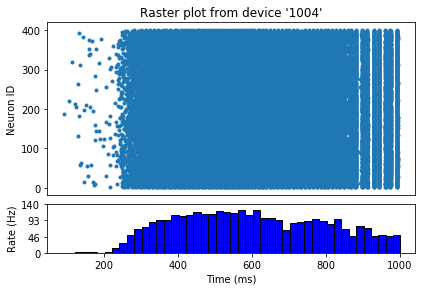

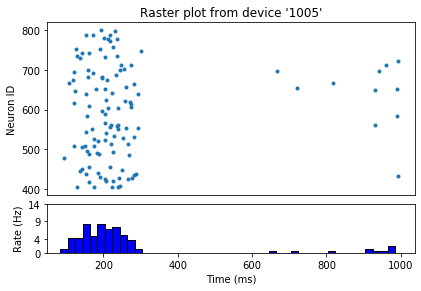

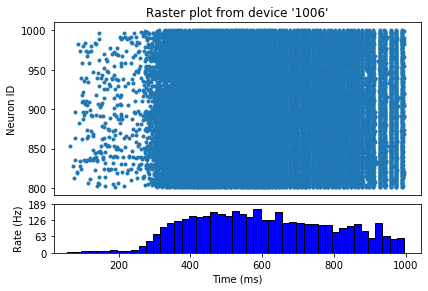

In [ ]:
nest.raster_plot.from_device(spikes_a, hist=True, hist_binwidth=20)
nest.raster_plot.from_device(spikes_b, hist=True, hist_binwidth=20)
nest.raster_plot.from_device(spikes_i, hist=True, hist_binwidth=20)
plt.show()